In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv("t.csv")

In [3]:
import emoji
def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [4]:
# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def text_preprocess(text):
    text = re.sub(r'#', '', text) #Replace the # symbol with '' in every tweet
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) #Replace hyperlinks with '' in every tweet
    text = re.sub(r'[^\w\d\s]+', '', text) #Remove all punctuations
    text = deEmoji(text) #Remove emoji
    text = re.sub(r'\n', '', text) #Remove \n
    
    #Remove all stopwords
    stopwords_eng = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    text = pattern.sub('', text)
    

    #Apply stem
    ps = PorterStemmer()
    tk = TweetTokenizer(preserve_case=False, strip_handles = True)
    tweet_tokens = tk.tokenize(text)
    tweet_finish = ''
    for token in tweet_tokens:
        stem = ps.stem(token)
        tweet_finish += (stem + ' ')
    return tweet_finish  


In [5]:
tweets = tweets[['medical_device', 'text']]

In [6]:
length = len(tweets.text)
for i in range(length):
    tweets.text.iloc[i] = text_preprocess(tweets.text.iloc[i])

In [7]:
tweets.head()

,medical_device,text
0,False,yall know i know im never leav boy alon jnj
1,False,superkelli 24 such funni scene jnj
2,False,jampjohnson flagform confirm continu possibl j...
3,False,jnj daili rsi hasnt touch 69 sinc februari 202...
4,False,we outstand opportun join non clinic safeti te...


In [8]:
tweets['medical_device'].value_counts()

False    5859
True      635
Name: medical_device, dtype: int64

## K-means tfidf

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

In [11]:
X = tfidf_vectorizer.fit_transform(tweets['text'])

In [12]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(X.shape)

['000', '00000', '00000000000', '00001', '0010', '00155817', '00245', '00390419', '007', '01']
(6494, 13740)


In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

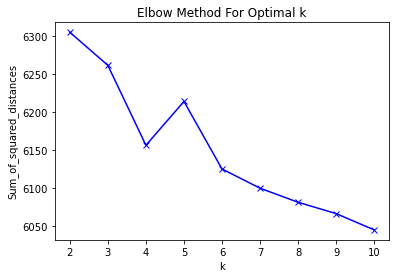

In [14]:
### Decide optimal K
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10,random_state=42)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

 K seems to be 4 or 6

### K=4

In [15]:

true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
tweets_cl=pd.DataFrame(list(zip(tweets['medical_device'],labels)),columns=['medical_device','cluster'])
print(tweets_cl.sort_values(by=['cluster','medical_device']))

      medical_device  cluster
4              False        0
8              False        0
9              False        0
10             False        0
24             False        0
...              ...      ...
5965            True        3
6164            True        3
6165            True        3
6204            True        3
6208            True        3

[6494 rows x 2 columns]


In [16]:
tweets_true=tweets_cl[tweets_cl['medical_device']==True]

In [17]:
### Cluster with true response
tweets_true['cluster'].value_counts().sort_index()

0    529
2     22
3     84
Name: cluster, dtype: int64

In [18]:
### number of tweets in every cluster
tweets_cl['cluster'].value_counts().sort_index()

0    2914
1     233
2    2926
3     421
Name: cluster, dtype: int64

In [19]:
### True response ratio
ratio=tweets_true['cluster'].value_counts()/tweets_cl['cluster'].value_counts()
print('True ratio of every cluster:\n',ratio)

True ratio of every cluster:
 0    0.181537
1         NaN
2    0.007519
3    0.199525
Name: cluster, dtype: float64


Cluster: 0
medical_device


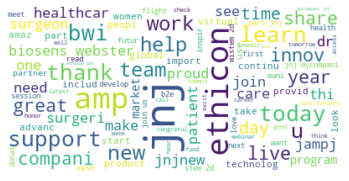

Cluster: 1
medical_device


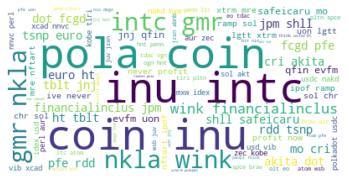

Cluster: 2
medical_device


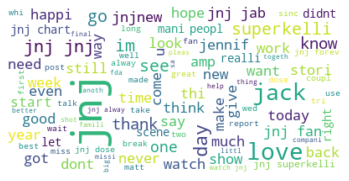

Cluster: 3
medical_device


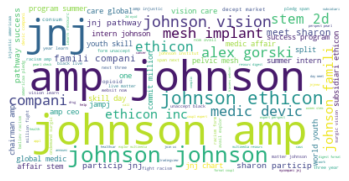

In [20]:
### Visulization

from wordcloud import WordCloud
result={'cluster':labels,'tweets':tweets['text']}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['tweets'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('medical_device')
    titles=tweets_cl[tweets_cl.cluster==k]['medical_device']
    # print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### K=6

In [21]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10,random_state=72)
model.fit(X)
labels=model.labels_
tweets_cl=pd.DataFrame(list(zip(tweets['medical_device'],labels)),columns=['medical_device','cluster'])
print(tweets_cl.sort_values(by=['cluster','medical_device']))

      medical_device  cluster
49             False        0
184            False        0
484            False        0
485            False        0
816            False        0
...              ...      ...
6464           False        5
6469           False        5
6470           False        5
6483           False        5
6493           False        5

[6494 rows x 2 columns]


In [22]:
tweets_true=tweets_cl[tweets_cl['medical_device']==True]

In [23]:
tweets_true['cluster'].value_counts().sort_index()

0    387
2    164
3     84
Name: cluster, dtype: int64

In [24]:
tweets_cl['cluster'].value_counts().sort_index()

0    1203
1     104
2    4148
3     421
4     129
5     489
Name: cluster, dtype: int64

In [25]:
ratio=tweets_true['cluster'].value_counts()/tweets_cl['cluster'].value_counts()
print('True ratio of every cluster:\n',ratio)

True ratio of every cluster:
 0    0.321696
1         NaN
2    0.039537
3    0.199525
4         NaN
5         NaN
Name: cluster, dtype: float64


Cluster: 0
medical_device


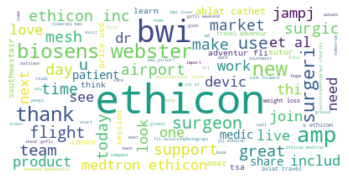

Cluster: 1
medical_device


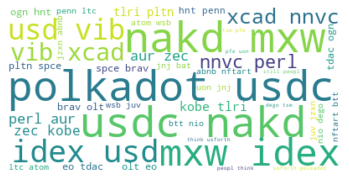

Cluster: 2
medical_device


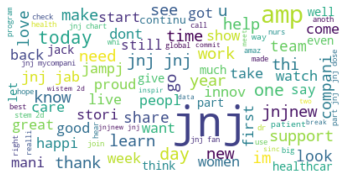

Cluster: 3
medical_device


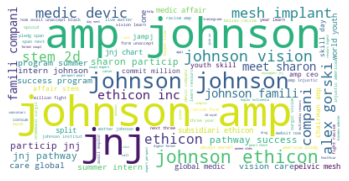

Cluster: 4
medical_device


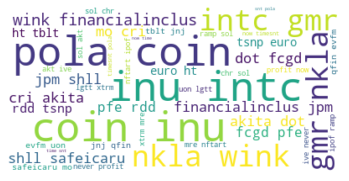

Cluster: 5
medical_device


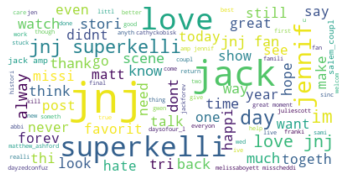

In [26]:
from wordcloud import WordCloud
result={'cluster':labels,'tweets':tweets['text']}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['tweets'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('medical_device')
    titles=tweets_cl[tweets_cl.cluster==k]['medical_device']
    # print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Updates ---- Black List

In [27]:
# Word Frequency

In [28]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

In [89]:
for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :150]:
        print(' %s' % terms[ind])

Cluster 0:
 ethicon
 bwi
 market
 airport
 biosens
 webster
 the
 surgic
 thank
 surgeri
 medtron
 mesh
 surgeon
 jampj
 cathet
 ablat
 travel
 new
 devic
 bwi_airport
 flight
 inc
 us
 fli
 great
 2020
 amp
 stapl
 look
 et
 day
 help
 use
 insur
 today
 work
 southwest
 team
 global
 support
 fda
 we
 liabil
 donat
 jnjmeddeviceuki
 get
 report
 southwestair
 al
 line
 advanc
 patient
 system
 product
 like
 technolog
 join
 atrial
 aviat
 first
 baltimor
 weight
 plane
 design
 what
 recal
 stapler
 train
 next
 sutur
 dr
 session
 pleas
 adventur
 make
 live
 md
 virtual
 time
 loss
 fibril
 carto
 sf
 3d
 no
 thermocool
 innov
 publish
 ventil
 intern
 medic
 tsa
 treat
 love
 includ
 well
 dont
 10
 wound
 health
 it
 aviationphotograpi
 clearski
 smarttouch
 see
 amaz
 year
 sunris
 usd
 echelon
 studi
 need
 prisma
 start
 gofli
 growth
 tissu
 weekend
 check
 smoke
 thi
 servic
 price
 manag
 print
 confer
 litig
 discuss
 aviationinsur
 pm
 launch
 airlin
 jnjinstitut
 excit


In [90]:
cluster_0_topword = [] # target cluster
cluster_1_topword = []
cluster_2_topword = []
cluster_3_topword = [] 
cluster_4_topword = []
cluster_5_topword = []

for i in range(6):
    for ind in order_centroids[i, :150]:
        exec(f'cluster_{i}_topword.append(terms[ind])')

In [94]:
check = any(item in cluster_0_topword for item in cluster_1_topword)
check

True

In [95]:
whole_set = set(cluster_1_topword +cluster_2_topword+cluster_4_topword+cluster_5_topword)
whole_list = list(whole_set)
black_list = whole_list

In [96]:
len(whole_list)

437

In [97]:
len(black_list)

437

In [98]:
black_list[:10]

['embodi',
 'nkla',
 'emin',
 'safeicaru',
 'got',
 'believ',
 'jab',
 'johnsonandjohnson',
 'part',
 'first']

In [99]:
#### Apply black list

In [100]:
tweets = pd.read_csv("t.csv")

In [101]:
import emoji
def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [102]:
# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def text_preprocess(text):
    text = re.sub(r'#', '', text) #Replace the # symbol with '' in every tweet
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) #Replace hyperlinks with '' in every tweet
    text = re.sub(r'[^\w\d\s]+', '', text) #Remove all punctuations
    text = deEmoji(text) #Remove emoji
    text = re.sub(r'\n', '', text) #Remove \n
    
    #Remove all stopwords
    stopwords_eng = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    text = pattern.sub('', text)
    

    #Apply stem
    ps = PorterStemmer()
    tk = TweetTokenizer(preserve_case=False, strip_handles = True)
    tweet_tokens = tk.tokenize(text)
    tweet_finish = ''
    for token in tweet_tokens:
        stem = ps.stem(token)
        tweet_finish += (stem + ' ')
    
    #Apply black list after stem
    
    pattern = re.compile(r'\b(' + r'|'.join(black_list) + r')\b\s*')
    tweet_finish=pattern.sub('',tweet_finish)
    
    return tweet_finish  


In [103]:
tweets = tweets[['medical_device', 'text']]

In [104]:
length = len(tweets.text)
for i in range(length):
    tweets.text.iloc[i] = text_preprocess(tweets.text.iloc[i])

In [105]:
tweets.head()

,medical_device,text
0,False,yall i leav boy alon
1,False,such funni
2,False,jampjohnson flagform confirm possibl
3,False,daili rsi hasnt touch 69 februari highjnj 15 m...
4,False,outstand non clinic safeti focus predict inves...


In [106]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X = tfidf_vectorizer.fit_transform(tweets['text'])

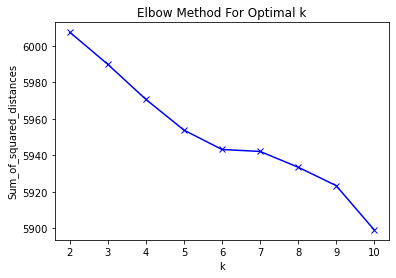

In [131]:
### Decide optimal K
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10,random_state=42)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [132]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10,random_state=72)
model.fit(X)
labels=model.labels_
tweets_cl=pd.DataFrame(list(zip(tweets['medical_device'],labels)),columns=['medical_device','cluster'])
print(tweets_cl.sort_values(by=['cluster','medical_device']))

      medical_device  cluster
0              False        0
1              False        0
2              False        0
3              False        0
4              False        0
...              ...      ...
5964            True        5
6265            True        5
6474            True        5
6475            True        5
6476            True        5

[6494 rows x 2 columns]


In [133]:
tweets_true=tweets_cl[tweets_cl['medical_device']==True]

In [134]:
tweets_true['cluster'].value_counts().sort_index()

0    200
1     83
2     56
3     31
5    265
Name: cluster, dtype: int64

In [135]:
ratio=tweets_true['cluster'].value_counts()/tweets_cl['cluster'].value_counts()
print('True ratio of every cluster:\n',ratio)

True ratio of every cluster:
 0    0.041102
1    0.199041
2    0.629213
3    0.184524
4         NaN
5    0.414062
Name: cluster, dtype: float64


Cluster: 0
medical_device


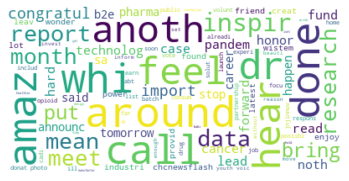

Cluster: 1
medical_device


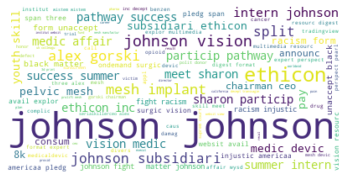

Cluster: 2
medical_device


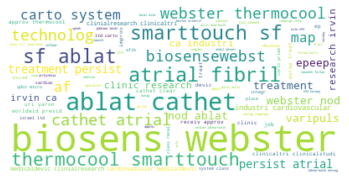

Cluster: 3
medical_device


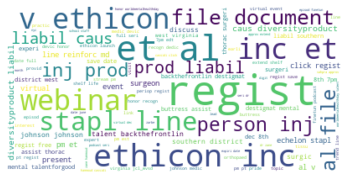

Cluster: 4
medical_device


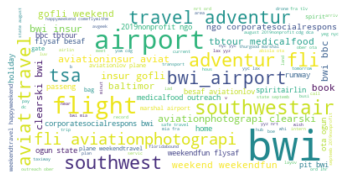

Cluster: 5
medical_device


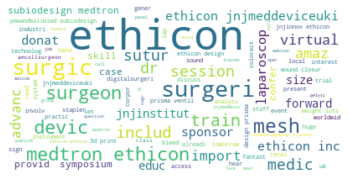

In [136]:
from wordcloud import WordCloud
result={'cluster':labels,'tweets':tweets['text']}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['tweets'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('medical_device')
    titles=tweets_cl[tweets_cl.cluster==k]['medical_device']
    # print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Kmeans w2v

In [137]:
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
tweets['clean_text_tok']=[nltk.word_tokenize(i) for i in tweets['text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(tweets['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [138]:
modelw = MeanEmbeddingVectorizer(w2v)
X=modelw.transform(tweets['text'])

In [139]:
X.shape

(6494, 100)

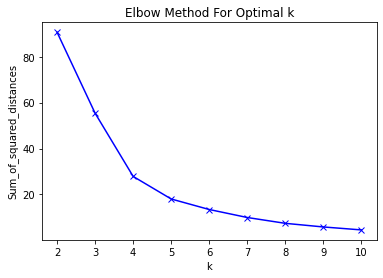

In [140]:
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10,random_state=42)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [142]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
tweets_cl_w2v=pd.DataFrame(list(zip(tweets['medical_device'],labels)),columns=['medical_device','cluster'])
print(tweets_cl_w2v.sort_values(by=['cluster','medical_device']))

      medical_device  cluster
1              False        0
2              False        0
4              False        0
5              False        0
7              False        0
...              ...      ...
5835            True        3
5886            True        3
5896            True        3
5948            True        3
5956            True        3

[6494 rows x 2 columns]


In [143]:
tweets_cl_w2v=pd.DataFrame(list(zip(tweets['medical_device'],labels)),columns=['medical_device','cluster'])

In [144]:
tweets_true=tweets_cl_w2v[tweets_cl_w2v['medical_device']==True]

In [145]:
tweets_true['cluster'].value_counts()/tweets_cl_w2v['cluster'].value_counts()

0    0.126735
1    0.001520
2         NaN
3    0.073361
Name: cluster, dtype: float64

In [146]:
tweets_cl_w2v['cluster'].value_counts()

0    3890
3    1922
1     658
2      24
Name: cluster, dtype: int64

### Upshot
* Narrow down the scope to some point. 
* Investigate into the cluster without true response could yield some key word in the black list corpus (later add into the stopword) 
* tfidf is better than w2v in terms of unsupervised models

## LDA

In [40]:
from gensim import corpora, models
from pprint import pprint

In [41]:
clean_corp = [tweet.split() for tweet in tweets['text']]
dictionary = corpora.Dictionary(clean_corp)
corpus = [dictionary.doc2bow(text) for text in clean_corp]

In [42]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word = dictionary, passes=20) # the same as cluster indicates

In [43]:
pprint(ldamodel.print_topics())
doc_lda = ldamodel[corpus]

[(0,
  '0.016*"jnj" + 0.013*"pfe" + 0.013*"sol" + 0.013*"uon" + 0.013*"nftart" + '
  '0.009*"usd" + 0.009*"peopl" + 0.008*"profit" + 0.007*"nkla" + 0.007*"mo"'),
 (1,
  '0.026*"ethicon" + 0.016*"jnj" + 0.008*"join" + 0.006*"may" + 0.005*"regist" '
  '+ 0.004*"surgeri" + 0.004*"thank" + 0.004*"today" + 0.004*"us" + '
  '0.004*"side"'),
 (2,
  '0.050*"johnson" + 0.028*"amp" + 0.024*"jnj" + 0.009*"bwi" + 0.008*"health" '
  '+ 0.007*"learn" + 0.007*"patient" + 0.006*"innov" + 0.006*"studi" + '
  '0.006*"resourc"'),
 (3,
  '0.071*"jnj" + 0.030*"i" + 0.011*"jack" + 0.009*"love" + 0.008*"get" + '
  '0.008*"one" + 0.006*"im" + 0.006*"jennif" + 0.006*"24" + 0.006*"know"'),
 (4,
  '0.044*"jnj" + 0.009*"use" + 0.009*"support" + 0.009*"the" + 0.008*"jab" + '
  '0.008*"stem" + 0.007*"amp" + 0.007*"share" + 0.007*"2d" + 0.007*"proud"'),
 (5,
  '0.043*"jnj" + 0.013*"amp" + 0.008*"johnson" + 0.007*"day" + 0.006*"jnjnew" '
  '+ 0.005*"get" + 0.005*"charlizeafrica" + 0.004*"medic" + 0.004*"help" + '
  '

In [44]:
tweet_topic = ldamodel[corpus]

In [45]:
topic=[]
for n in range(len(tweet_topic)):
    dic = dict(tweet_topic[n])
    topic.append(max(dic, key=dic.get))

In [46]:
len(topic)

6494

In [47]:
tweets['topic']=topic
tweets.head()

,medical_device,text,clean_text_tok,topic
0,False,yall know i know im never leav boy alon jnj,"[yall, know, i, know, im, never, leav, boy, al...",3
1,False,superkelli 24 such funni scene jnj,"[superkelli, 24, such, funni, scene, jnj]",3
2,False,jampjohnson flagform confirm continu possibl j...,"[jampjohnson, flagform, confirm, continu, poss...",3
3,False,jnj daili rsi hasnt touch 69 sinc februari 202...,"[jnj, daili, rsi, hasnt, touch, 69, sinc, febr...",3
4,False,we outstand opportun join non clinic safeti te...,"[we, outstand, opportun, join, non, clinic, sa...",2


In [48]:
### topic distribution
tweets.topic.value_counts().sort_index()

0     523
1     698
2     958
3    2408
4    1183
5     724
Name: topic, dtype: int64

In [49]:
### true response distribution
tweets[tweets['medical_device']==True].topic.value_counts().sort_index()

0     46
1    165
2    192
3     40
4     75
5    117
Name: topic, dtype: int64

In [50]:
### true ratio in topics
tweets[tweets['medical_device']==True].topic.value_counts().sort_index()/tweets.topic.value_counts().sort_index()

0    0.087954
1    0.236390
2    0.200418
3    0.016611
4    0.063398
5    0.161602
Name: topic, dtype: float64